In [58]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import pandas as pd
from keras.utils import np_utils
%matplotlib inline

## Logic Based FizzBuzz Function [Software 1.0]

In [59]:
def fizzbuzz(n):
    
    # Logic Explanation
    if n % 3 == 0 and n % 5 == 0:
        return 'FizzBuzz'
    elif n % 3 == 0:
        return 'Fizz'
    elif n % 5 == 0:
        return 'Buzz'
    else:
        return 'Other'

## Create Training and Testing Datasets in CSV Format

In [60]:
def createInputCSV(start,end,filename):
    
    # Why list in Python?
    ### List can be edited when we need. List can include int, string and other list, it is powerful.
    inputData   = []
    outputData  = []
    
    # Why do we need training Data?
    ### We want to make program be supervised learning, so we need some training Data with answer.
    for i in range(start,end):
        inputData.append(i)
        outputData.append(fizzbuzz(i))
    
    # Why Dataframe?
    ### Dataframe from pandas has very powerful skill to make a form like execl. 
    ### It is very flexible. We can define how many rows and columns does the form have.
    dataset = {}
    dataset["input"]  = inputData
    dataset["label"] = outputData
    
    # Writing to csv
    pd.DataFrame(dataset).to_csv(filename)
    ### print(pd.DataFrame(dataset))
    print(filename, "Created!")

## Processing Input and Label Data

In [61]:
def processData(dataset):
    
    # Why do we have to process?
    ### After we edcode the data, the original data will be transfer into binary number
    ### (1/0) which neural networks easy to understand. 
    data   = dataset['input'].values
    labels = dataset['label'].values
    
    processedData  = encodeData(data)
    processedLabel = encodeLabel(labels)
    
    return processedData, processedLabel

In [62]:
import numpy as np

def encodeData(data):
    
    processedData = []
    
    for dataInstance in data:
        
        # Why do we have number 10?
        ### There is 1000 numbers. Because 2**10 = 1024, so 10 number can include all the training data.
        processedData.append([dataInstance >> d & 1 for d in range(10)])
    
    return np.array(processedData)

In [63]:
def encodeLabel(labels):
    
    processedLabel = []
    
    for labelInstance in labels:
        if(labelInstance == "FizzBuzz"):
            # Fizzbuzz
            processedLabel.append([3])
        elif(labelInstance == "Fizz"):
            # Fizz
            processedLabel.append([1])
        elif(labelInstance == "Buzz"):
            # Buzz
            processedLabel.append([2])
        else:
            # Other
            processedLabel.append([0])

    return np_utils.to_categorical(np.array(processedLabel),4)

In [64]:
# Create datafiles
createInputCSV(101,1001,'training.csv')
createInputCSV(1,101,'testing.csv')

training.csv Created!
testing.csv Created!


In [65]:
# Read Dataset
trainingData = pd.read_csv('training.csv')
testingData  = pd.read_csv('testing.csv')

# Process Dataset
processedTrainingData, processedTrainingLabel = processData(trainingData)
processedTestingData, processedTestingLabel   = processData(testingData)

## Tensorflow Model Definition

In [66]:
# Defining Placeholder
inputTensor  = tf.placeholder(tf.float32, [None, 10])
outputTensor = tf.placeholder(tf.float32, [None, 4])

In [89]:
NUM_HIDDEN_NEURONS_LAYER_1 = 500      ###edited, original is 100
LEARNING_RATE = 0.05             ###edited, original is 0.05

# Initializing the weights to Normal Distribution
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

# Initializing the input to hidden layer weights
input_hidden_weights  = init_weights([10, NUM_HIDDEN_NEURONS_LAYER_1])
# Initializing the hidden to output layer weights
hidden_output_weights = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, 4])

# Computing values at the hidden layer
hidden_layer = tf.nn.relu6(tf.matmul(inputTensor, input_hidden_weights)) ### Original is tf.nn.relu
# Computing values at the output layer
output_layer = tf.matmul(hidden_layer, hidden_output_weights)

# Defining Error Function
error_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output_layer, labels=outputTensor))


# Defining Learning Algorithm and Training Parameters
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)

# Prediction Function
prediction = tf.argmax(output_layer, 1)

# Training the Model

In [90]:
NUM_OF_EPOCHS = 5000
BATCH_SIZE = 128
loss = []
training_accuracy = []

with tf.Session() as sess:
    
    # Set Global Variables ?
    ### When we set some Variables in tensorflow, we must use tf.global_variables_initializer() to initial 
    ### the variables before we training.
    tf.global_variables_initializer().run()
    
    for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):
        
        #Shuffle the Training Dataset at each epoch
        p = np.random.permutation(range(len(processedTrainingData)))
        processedTrainingData  = processedTrainingData[p]
        processedTrainingLabel = processedTrainingLabel[p]
        
        # Start batch training
        for start in range(0, len(processedTrainingData), BATCH_SIZE):
            end = start + BATCH_SIZE
            sess.run(training, feed_dict={inputTensor: processedTrainingData[start:end], 
                                          outputTensor: processedTrainingLabel[start:end]})
            
        # Training accuracy for an epoch
        training_accuracy.append(np.mean(np.argmax(processedTrainingLabel, axis=1) ==
                             sess.run(prediction, feed_dict={inputTensor: processedTrainingData,
                                                             outputTensor: processedTrainingLabel})))
        
        loss.append(sess.run(error_function,feed_dict={inputTensor: processedTrainingData,
                                                             outputTensor: processedTrainingLabel}))
    # Testing
    predictedTestLabel = sess.run(prediction, feed_dict={inputTensor: processedTestingData})
    #print(training_accuracy)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001964CD5DC88>,
      dtype=object)

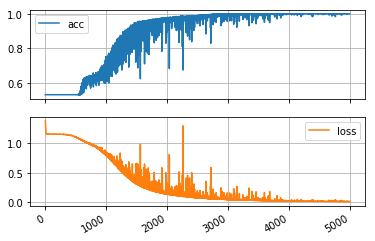

In [91]:
df = pd.DataFrame()
df['acc'] = training_accuracy
df['loss'] = loss
df.plot(subplots=True,grid=True)

#print(training_accuracy)
#print(loss)


In [92]:
def decodeLabel(encodedLabel):
    if encodedLabel == 0:
        return "Other"
    elif encodedLabel == 1:
        return "Fizz"
    elif encodedLabel == 2:
        return "Buzz"
    elif encodedLabel == 3:
        return "FizzBuzz"

# Testing the Model [Software 2.0]

Errors: 2  Correct :98
Testing Accuracy: 98.0


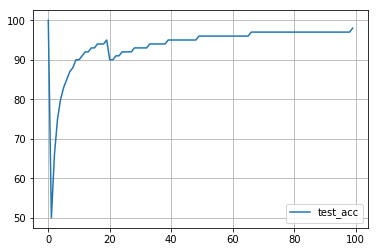

In [93]:
wrong   = 0
right   = 0

predictedTestLabelList = []
df2 = pd.DataFrame()
test_acc = []
for i,j in zip(processedTestingLabel,predictedTestLabel):
    predictedTestLabelList.append(decodeLabel(j))
    
    if np.argmax(i) == j:
        right = right + 1
    else:
        wrong = wrong + 1
    test_acc.append(int(right/(right+wrong)*100))
df2['test_acc'] = test_acc
df2.plot(grid=True)

print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(right/(right+wrong)*100))


# Please input your UBID and personNumber 
testDataInput = testingData['input'].tolist()
testDataLabel = testingData['label'].tolist()

testDataInput.insert(0, "UBID")
testDataLabel.insert(0, "50291149")

testDataInput.insert(1, "personNumber")
testDataLabel.insert(1, "50291149")

predictedTestLabelList.insert(0, "")
predictedTestLabelList.insert(1, "")

output = {}
output["input"] = testDataInput
output["label"] = testDataLabel

output["predicted_label"] = predictedTestLabelList

opdf = pd.DataFrame(output)
opdf.to_csv('output.csv')
